In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
#from IPython.display import Image
root_url = "https://planetarycomputer.microsoft.com/api/stac/v1"

def showim(i):
    import matplotlib.pyplot as plt
    plt.imshow(i if len(i.shape) == 2 else i[:,:,:3][:,:,::-1])
    plt.axis("off")
    plt.show()

In [11]:
#download full previews from server

In [12]:
import requests
def download_preview(item0, trg_name, trg_format=None):
    if trg_format is None:
        trg_format = trg_name.split('.')[-1].lower().replace('jpeg','jpg')
    preview_url = item0.assets.get("rendered_preview").href
    if trg_format != 'png':
        preview_url = preview_url.replace('png',trg_format)
    response = requests.get(preview_url)
    if response.status_code != 200:
        return -1
    with open(trg_name, "wb") as f:
        f.write(response.content)
        return f.tell()
    
import pystac
import tqdm.auto as tqdm

sleep_between_calls = 1.1
trg_dir = '/workspace/naip_dwnl/preview/'
os.makedirs(trg_dir, exist_ok=True)
for i in tqdm.tqdm(range(len(all_json_gz_paths))):
    time.sleep(sleep_between_call)
    try:
        j_path = all_json_gz_paths[i]
        with gzip.open(j_path, "r") as f:
            j0 = json.load(f)
    
        item0 = pystac.read_dict(j0)
        trg_name = trg_dir+'/'+j0['sid']['sid']+'.jpg'
        if os.path.exists(trg_name):
            continue
        download_preview(item0,trg_name)
    except:
        pass

  0%|          | 0/10578 [00:00<?, ?it/s]

In [ ]:
#download full data from server, 0.6m spatial res

In [4]:
import glob, gzip, os, json, time
src_json_dir = '/workspace/naip_dwnl/jsons_train'
all_json_gz_paths = list(sorted(glob.glob(src_json_dir+'/*.json.gz')))

In [5]:
import planetary_computer
import requests
import rasterio
from rasterio.shutil import copy as rio_copy
from pystac_client import Client
#from rasterio.env import set_defaults

def download_geotiff(item0, dst_path, naip_coll=None, sleep_between_sec=0.1):
    if not naip_coll is None:#refresh old url with object from catalog.get_collection("naip")
        item0 = naip_coll.get_item(item0.id)
        time.sleep(sleep_between_sec)
        
    signed_item = planetary_computer.sign(item0)
    image_url = signed_item.assets.get("image").href
    with rasterio.Env():
        with rasterio.open(image_url) as src:
            profile = src.profile.copy()
            profile.update({
                "driver": "GTiff",
                "compress": "none"  # No compression = lossless
            })
            rio_copy(src, dst_path, **profile)
    
import pystac
import tqdm.auto as tqdm

sleep_between_calls = 1.1
trg_dir = '/workspace/naip_dwnl/tmpgeotiffs/'
os.makedirs(trg_dir, exist_ok=True)
naip_coll = Client.open(root_url, modifier=planetary_computer.sign_inplace).get_collection("naip")
for i in tqdm.tqdm(range(len(all_json_gz_paths))):
    bad_downl = False
    try:
        j_path = all_json_gz_paths[i]
        with gzip.open(j_path, "r") as f:
            j0 = json.load(f)
    
        item0 = pystac.read_dict(j0)
        trg_name = trg_dir+'/'+j0['sid']['sid']+'.tif'
        if os.path.exists(trg_name):
            continue
        download_geotiff(item0, trg_name, naip_coll)
        time.sleep(sleep_between_calls)
        got_sz = os.path.getsize(dst_path)
        bad_downl = got_sz < 5000000
    except:
        bad_downl = True
    if bad_downl: #reopen Client object
        naip_coll = Client.open(root_url, modifier=planetary_computer.sign_inplace).get_collection("naip")

  0%|          | 0/2890 [00:00<?, ?it/s]

In [174]:
#download only roi from server; add padding to allow centered & left-top 2X versions

In [18]:
import planetary_computer
import rasterio
from pystac_client import Client

import glob, gzip, os, json, time
root_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
src_file = '/workspace/naip_dwnl/sids_meta.json.gz'
with gzip.open(src_file, "r") as f:
    sids_meta = json.load(f)
naip_coll = Client.open(root_url, modifier=planetary_computer.sign_inplace).get_collection("naip")

In [345]:
from rasterio.transform import rowcol
import mercantile# !pip install mercantile
import tqdm.auto as tqdm

def webmercator2bbox4326(x,y,z):
    tile = mercantile.Tile(x=x, y=y, z=z)
    return  mercantile.bounds(tile) # EPSG:4326 (WGS84)

#item0 = naip_coll.get_item(item0['id'])
#padding allows x2 both with original roi centered or in the left/top corner
def download_roi(item0, bbox_4326, trg_filepath, pad_view=[[-0.55,-0.55],[1.05,1.05]], min_dim=320):
    signed_item = planetary_computer.sign(item0)
    signed_url = signed_item.assets.get("image").href
    with rasterio.Env():
        with rasterio.open(signed_url) as src:
            src_max_hw = [src.height-1, src.width-1]
            transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)        
            coords_trg_crs = [transformer.transform(bbox_4326.west, bbox_4326.north), transformer.transform(bbox_4326.east, bbox_4326.south)]
            roi_corners = [rowcol(src.transform, coords_trg_crs[j][0], coords_trg_crs[j][1]) for j in range(2)] #(x0,y0), (x1,y1)
            if not pad_view is None:
                roi_hw = [roi_corners[1][j]-roi_corners[0][j] for j in range(2)]
                roi_corners = [[int(roi_hw[c]*pad_view[j][1-c])+roi_corners[j][c] for c in range(2)] for j in range(2)]
            #clip coords
            roi_corners = [[max(min(src_max_hw[c], roi_corners[j][c]),0)  for c in range(2)] for j in range(2)]
            window = ((roi_corners[0][0], roi_corners[1][0]), (roi_corners[0][1], roi_corners[1][1])) # [(y0,y1), (x0,x1)]
            
            if min([window[i][1]-window[i][0]  for i in range(2)]) < min_dim:
                return
            
            roi_data = src.read(window=window)
            meta = src.meta.copy()
            meta.update({
                "driver": "GTiff",
                "height": roi_data.shape[1],  # rows
                "width": roi_data.shape[2],   # cols
                "transform": src.window_transform(window),
                "crs": src.crs
            })
            with rasterio.open(trg_filepath, "w", **meta) as dst:
                dst.write(roi_data)

trg_dir = '/workspace/naip_dwnl/val_tmptiffs'
os.makedirs(trg_dir, exist_ok=True)
naip_coll = Client.open(root_url, modifier=planetary_computer.sign_inplace).get_collection("naip")
cnt0 = 0
sleep_between_calls = 1.1
sleep_before_sign = 0.1
cnt0 = 0
for k, v in tqdm.tqdm(sids_meta['tiles_val'].items()):
    item0 = None
    for t0 in v:
        bad_downl = False
        trg_filepath = trg_dir+f'/{k}_{t0}.tif'
        if os.path.exists(trg_filepath):
            continue
        xy = [int(c) for c in t0.split('_')]
        bbox_4326 = webmercator2bbox4326(xy[0],xy[1],17)# all satlas coords are of z==17
        if item0 is None:
            item0 = naip_coll.get_item(sids_meta['sids'][k]['id'])
            time.sleep(sleep_before_sign)
        download_roi(item0, bbox_4326, trg_filepath)
        time.sleep(sleep_between_calls)

  0%|          | 0/7688 [00:00<?, ?it/s]

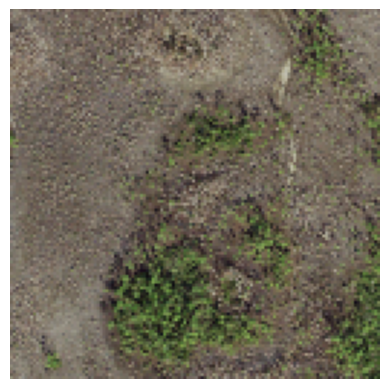

In [323]:
#eval one result
import cv2
k = 'm_2508108_se_17_060_20191130'
t0 = '36039_55754'
orig_path = f'/workspace/satlas/val_set/naip/{k}/{t0}/rgb.png'
showim(cv2.imread(orig_path))

In [338]:
#download full tile for debugging
item0 = naip_coll.get_item(sids_meta['sids'][k]['id'])
tmp_path = f'/workspace/naip_dwnl/tmpgeotiffs/{k}.tif'
download_geotiff(item0, tmp_path, naip_coll)

In [324]:
#debug roi
tmp_path = f'/workspace/naip_dwnl/val_tmptiffs/{k}_{t0}.tif'

In [343]:
src = rasterio.open(tmp_path)

In [344]:
xy = [int(c) for c in t0.split('_')]
bbox_4326 = webmercator2bbox4326(xy[0],xy[1],17)
src_max_hw = [src.height-1, src.width-1]
transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)        
coords_trg_crs = [transformer.transform(bbox_4326.west, bbox_4326.north), transformer.transform(bbox_4326.east, bbox_4326.south)]
roi_corners = [rowcol(src.transform, coords_trg_crs[j][0], coords_trg_crs[j][1]) for j in range(2)] #(y0,x0), (y1,x1)

#if not pad_view is None:
#    roi_hw = [roi_corners[1][j]-roi_corners[0][j] for j in range(2)]
#    roi_corners = [[int(roi_hw[c]*pad_view[j][1-c])+roi_corners[j][c] for c in range(2)] for j in range(2)]
#clip coords
roi_corners = [[max(min(src_max_hw[c], roi_corners[j][c]),0)  for c in range(2)] for j in range(2)]
window = ((roi_corners[0][0], roi_corners[1][0]), (roi_corners[0][1], roi_corners[1][1])) # [(y0,y1), (x0,x1)]

print([window[i][1]-window[i][0]  for i in range(2)])

[462, 462]


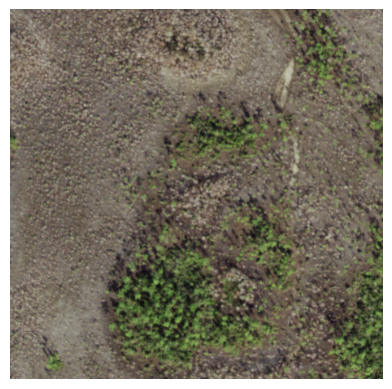

In [330]:
roi_data = src.read(window=window)
showim(np.transpose(roi_data,(1,2,0))[:,:,:3][:,:,::-1])

In [332]:
#roi_data = src.read()
#showim(np.transpose(roi_data,(1,2,0))[:,:,:3][:,:,::-1])

In [ ]:
#automatic extraction/search for correct sid from partial id from satlas paths
import tqdm.auto as tqdm
import json, gzip, os


def parse_shortid(shortid):
    shortid_spl = shortid.split('_')
    sdict = {
        'sid': shortid,
        'qid': shortid_spl[0]+'_'+shortid_spl[1], #quadrangle_id
        'quadrant': shortid_spl[2],
        'utm_zone': int(shortid_spl[3]),
        'resolution': int(shortid_spl[4])/100, # this is in cm
        'year':int(shortid_spl[5][:4]),
        'month':int(shortid_spl[5][4:6]),
        'day':int(shortid_spl[5][6:8]),
    }
    return sdict

def parse_naip_path(naip_path):
    p_split = naip_path.split('/')
    coord_spl = p_split[-2].split('_')
    sdict = parse_shortid(p_split[-3])
    sdict.update({'x_offset':int(coord_spl[0]), 'y_offset':int(coord_spl[1])})
    return sdict

root_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
#root_satlas_dir = '/workspace/satlas/train_urban_set'
root_satlas_dir = '/workspace/satlas/val_set'
all_naip_paths = glob.glob(root_satlas_dir+'/naip/*')
all_naip_paths = [sorted(glob.glob(f+'/*'))[0]+'/rgb.png' for f in all_naip_paths]
all_sdicts = [parse_naip_path(p) for p in all_naip_paths]

max_time = 4.5
sleep_between_sec = 0.3
sleep_between_call = 1.1

trg_dir = '/workspace/naip_dwnl/jsons_train'
os.makedirs(trg_dir, exist_ok=True)
catalog = Client.open(root_url, modifier=planetary_computer.sign_inplace)

for i in tqdm.tqdm(range(len(all_sdicts))):
    time.sleep(sleep_between_call)
    bad_try, sdict, item0 = False, all_sdicts[i], None
    try:
        check_date_s = "%04i-%02i-%02i"%(sdict['year'], sdict['month'], sdict['day'])
        check_date_e = check_date_s
        bbox = utm_zone2usa_bbox(sdict['utm_zone'])
        id_filter_part = f"%_{sdict['qid']}_{sdict['quadrant']}%"
        t0 = time.time()
        search = catalog.search(
            collections=["naip"],
            limit=1,
            datetime=f"{check_date_s}/{check_date_e}",  # exact time window
            filter_lang="cql2-json",
            filter={
                "op": "like",
                "args": [{"property": "id"}, id_filter_part]
            }
        )
        t1 = time.time()
        time.sleep(sleep_between_sec)
        t2 = time.time()
        item0 = list(search.item_collection())[0].to_dict()
        t3 = time.time()
        search.pages().close()
        item0['t_q'] = t1-t0
        item0['t_f'] = t3-t2
        bad_try = (not sdict['sid'] in item0['id']) or ((item0['t_q'] + item0['t_f'])>max_time)
    except:
        bad_try = True
    if bad_try:
        catalog = Client.open(root_url, modifier=planetary_computer.sign_inplace)
    if not item0 is None:
        trg_file = trg_dir+'/'+sdict['sid']+'.json.gz'
        item0['sid'] = sdict
        with gzip.open(trg_file, "wt") as f:
            json.dump(item0,f)

In [25]:
all_xy = np.array([[s['x_offset'],s['y_offset']] for s in all_sdicts])

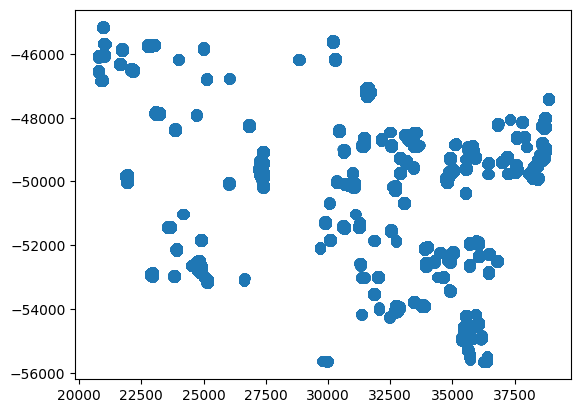

In [26]:
plt.scatter(all_xy[:,0], -all_xy[:,1]) #train_set

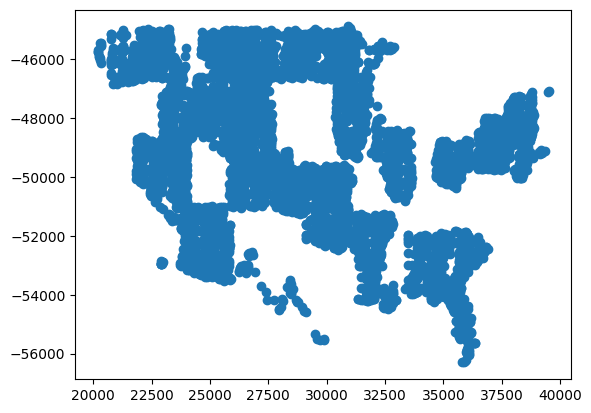

In [3]:
plt.scatter(all_xy[:,0], -all_xy[:,1]) #val_set

In [ ]:
#compression/removal of unnecessary details; consolidation of tiling
import tqdm.auto as tqdm
import glob, gzip, os, json, time
src_json_dir = '/workspace/naip_dwnl/jsons_val'
all_json_gz_paths = list(sorted(glob.glob(src_json_dir+'/*.json.gz')))
src_json_dir = '/workspace/naip_dwnl/jsons_train'
all_json_gz_paths += list(sorted(glob.glob(src_json_dir+'/*.json.gz')))

all_cont = {}
for i in tqdm.tqdm(range(len(all_json_gz_paths))):
    j_path = all_json_gz_paths[i]
    with gzip.open(j_path, "r") as f:
        j0 = json.load(f)
    all_cont[j0['sid']['sid']] = j0
    
for k, v in all_cont.items():
    _ = v['sid'].pop('x_offset', None)
    _ = v['sid'].pop('y_offset', None)

In [ ]:
root_satlas_dir_train = '/workspace/satlas/train_urban_set'
root_satlas_dir_val = '/workspace/satlas/val_set'
all_paths = [glob.glob(r_dir+'/naip/*') for r_dir in [root_satlas_dir_train,root_satlas_dir_val]]
#format {sid:list(webmercator_tiles)} for both train and val
tiles = [{f.split('/')[-1]:sorted([d.split('/')[-1] for d in glob.glob(f+'/*')])  
          for f in all_paths_split} for all_paths_split in all_paths]
tile2sid = {}
for i,tiles_split in enumerate(tiles):
    for k, v in tiles_split.items():
        for v1 in v:
            tile2sid.setdefault(v1,[]).append(f"{i}/{k}")
assert len([k for k,v in tile2sid.items() if len(v) > 2]) == 0 #either once or doublicate
sid_doubles = {k:v for k,v in tile2sid.items() if len(v) > 1 and len(set([p.split('/')[-1] for p in v]))== 1}
assert len([k for k,v in tile2sid.items() if len(v) > 1]) == len(sid_doubles) #no weirdness otherwise
sid_doubles = {k: v[0].split('/')[-1] for k, v in sid_doubles.items()} # can keep compressed version
print([sum([len(v) for v in tiles[i].values()]) for i in range(2)], len(sid_doubles))

In [ ]:
res0 = {'sids':all_cont,'tiles_val':tiles[1], 'tiles_train':tiles[0], 'sid_doubles':sid_doubles}
trg_file = '/workspace/naip_dwnl/sids_meta.json.gz'
with gzip.open(trg_file, "wt") as f:
    json.dump(res0,f, sort_keys = True)

In [ ]:
#graveyard

In [ ]:
# method to find old NAIP data by partial id matching
#!pip install pystac==1.11.0 planetary_computer rioxarray rasterio
from pystac_client import Client
import planetary_computer
import time

def utm2lon(utm_zone):
    return [-180 + (utm_zone - 1) * 6, -180 + utm_zone * 6]

def utm_zone2usa_bbox(utm_zone):
    lon = utm2lon(utm_zone)
    return [lon[0], 24.0, lon[1], 50.0]

def find_item(sdict, max_num_pass=1, search_url=root_url):
    check_date_s = "%04i-%02i-%02i"%(sdict['year'], sdict['month'], sdict['day'])
    check_date_e = check_date_s
    bbox = utm_zone2usa_bbox(sdict['utm_zone'])
    id_filter_part = f"%_{sdict['qid']}_{sdict['quadrant']}%"
    catalog = Client.open(search_url)
    for pass0 in range(max_num_pass):
        print(pass0, check_date_s, check_date_e, id_filter_part)
        t0 = time.time()
        if pass0 == 0: #try full identifier
            max_exp = 1
            search = catalog.search(
                collections=["naip"],
                datetime=f"{check_date_s}/{check_date_e}",  # exact time window
                filter_lang="cql2-json",
                filter={
                    "op": "like",
                    "args": [{"property": "id"}, id_filter_part]
                }
            )
        elif pass0 == 1: #try area and exact date
            max_exp = 400
            search = catalog.search(
                collections=["naip"],
                datetime=f"{check_date_s}/{check_date_e}",  # exact time window
                bbox = bbox,
            )
        else: #try without bbox
            max_exp = 400
            search = catalog.search(
                collections=["naip"],
                datetime=f"{check_date_s}/{check_date_e}",  # exact time window
            )
        t1 = time.time()
        time.sleep(0.01)
        t1 = time.time()
        print('coll', search, t1-t0)
        item0 = None
        items = search.item_collection()
        for i,s in enumerate(items):
            if i > max_exp:
                break
            if sdict['sid'] in s.id:
                item0 = s
                t2 = time.time()
                break
        if not item0 is None:
            t2 = time.time()
            break
    print('fnd', item0, t2-t1)
    return item0